# Exercise 5

With PyTorch, we can use the `torch.nn.Conv2d` class to perform (and learn) convolution over 2D input tensors, e.g. images.

In [1]:
import torch
import torch.nn as nn

in_channels = 1
out_channels = 2
filter_size = (3, 3)
conv1 = nn.Conv2d(in_channels, out_channels, filter_size)

In this notebook, we will not learn the weights in this convolutional module, but replace them with some well-known kernels. One is an edge-detection kernel, the other a blurring kernel.

In [2]:
edge_detection_kernel = 1.0/10 * torch.tensor([[ -1, -1, -1 ], [-1, 8, -1], [-1, -1, -1]], dtype=torch.float)
blur_kernel = 1.0/9 * torch.tensor([[ 1, 1, 1 ], [1, 1, 1], [1, 1, 1]], dtype=torch.float)

conv1.weight.data = torch.stack((edge_detection_kernel.unsqueeze(0), blur_kernel.unsqueeze(0)))
conv1.bias.data = torch.tensor([128, 0], dtype=torch.float)

To test these kernels, we load an example image:

C:\Users\mhdmu\AppData\Local\Temp\ipykernel_8400\280373180.py:3: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  img = face(gray=True)


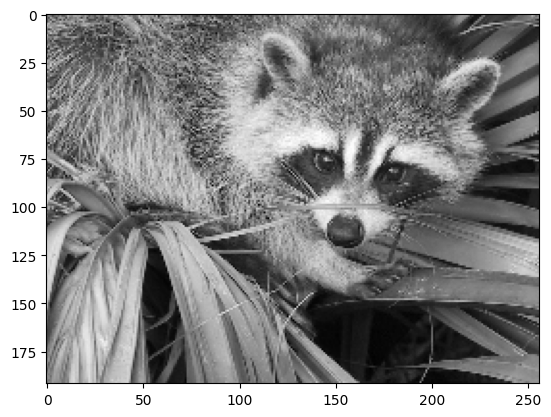

In [3]:
from scipy.misc import face

img = face(gray=True)
img = img[::4, ::4] # scale-down image to decrease computation time

import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(img, cmap='gray')
plt.show()

Now we can calculate the result of performing these convolutions on our test image:

In [4]:
img_torch = torch.as_tensor(img.copy(), dtype=torch.float)
img_torch = img_torch.unsqueeze(0).unsqueeze(0) # Add one dimension for channel and one for batch

conv1_result = conv1(img_torch)

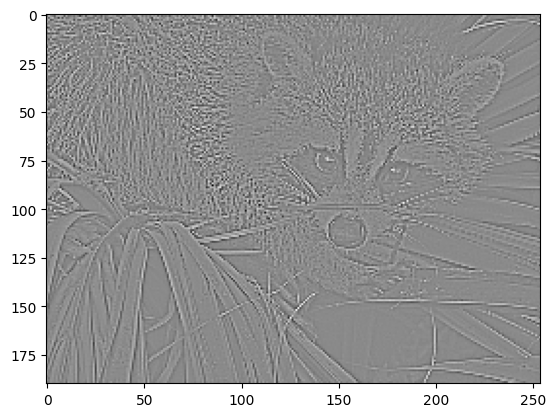

Image minimum value: 15.599991
Image maximum value: 223.79999


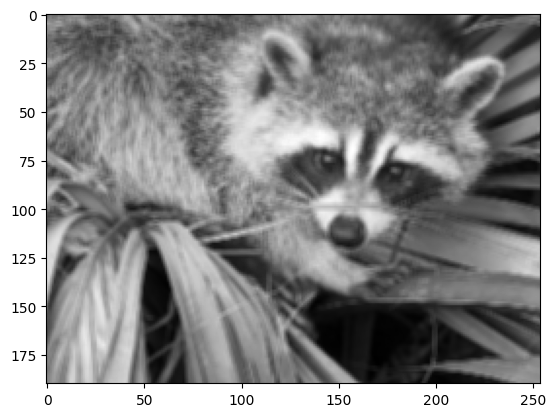

Image minimum value: 4.333333
Image maximum value: 242.77777


In [5]:
def disp_result(result):
    for channel in range(out_channels):
        res_img = result[0, channel].detach().numpy()
        plt.imshow(res_img, cmap='gray')
        plt.show()
        print("Image minimum value:", res_img.min())
        print("Image maximum value:", res_img.max())

disp_result(conv1_result)

As we can see, the result matches our expectations. The first kernel detects edges in the image, while the second kernel blurred the input image.

Your task in this network is to manually implement a class that performs the same operation as `Conv2d`. That is, it slides a weight tensor over the input image, performs element-wise multiplication between the weights and the matching region, and sums up the results (plus the bias). You can implement this with a few nested for-loops in the `forward()` method of the below class.

In [6]:
import torch
import torch.nn as nn

class ConvLayer2D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(ConvLayer2D, self).__init__()

        # Initialize weights and biases
        weight_shape = (out_channels, in_channels, *kernel_size)
        self.weight = nn.Parameter(torch.empty(weight_shape, requires_grad=True))
        self.bias = nn.Parameter(torch.empty(out_channels, requires_grad=True))

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        # Use He initialization for weights and zero initialization for biases
        nn.init.kaiming_uniform_(self.weight.data)
        nn.init.zeros_(self.bias.data)

    def forward(self, x):
        # Ensure input channels match
        assert x.shape[1] == self.in_channels

        # Calculate padding offsets
        dy = (self.kernel_size[0] - 1) // 2
        dx = (self.kernel_size[1] - 1) // 2

        # Allocate result tensor of the correct size
        result = torch.zeros(
            (x.shape[0], self.out_channels, x.shape[-2] - 2 * dy, x.shape[-1] - 2 * dx), device=x.device
        )

        # Perform the convolution manually using nested loops
        for batch in range(x.shape[0]):
            for channel_out in range(self.out_channels):
                for y in range(dy, x.shape[-2] - dy):
                    for x_coord in range(dx, x.shape[-1] - dx):
                        # Perform element-wise multiplication and summation
                        conv_result = (self.weight[channel_out] * x[batch, :, y - dy:y + dy + 1, x_coord - dx:x_coord + dx + 1]).sum()
                        result[batch, channel_out, y - dy, x_coord - dx] = conv_result + self.bias[channel_out]

        return result

To test your implementation, you can run the below code to perform the convolution with your module. The result should be the same as with the pytorch `Conv2d` class.

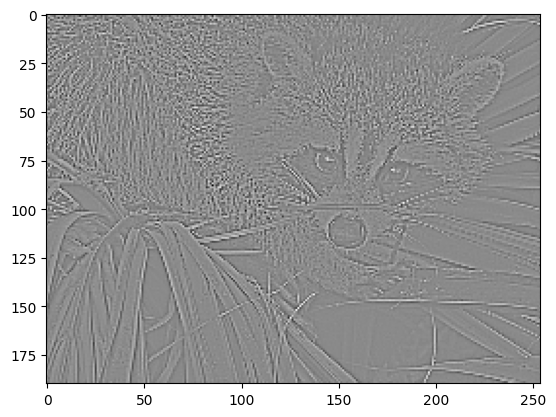

Image minimum value: 15.599998
Image maximum value: 223.8


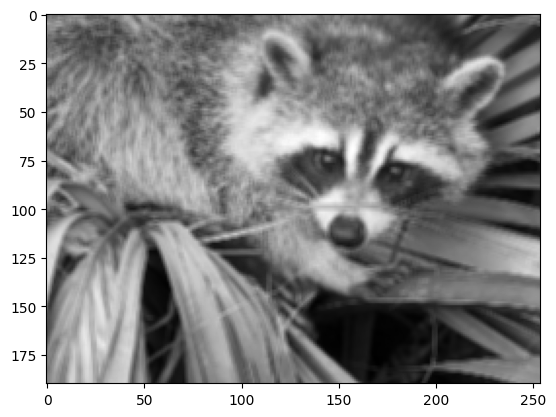

Image minimum value: 4.3333335
Image maximum value: 242.77777


In [7]:
conv2 = ConvLayer2D(in_channels, out_channels, filter_size)
conv2.weight.data = conv1.weight.data
conv2.bias.data = conv1.bias.data

conv2_result = conv2(img_torch)
disp_result(conv2_result)

assert(torch.allclose(conv1_result, conv2_result))